In [1]:
# ! pip install tensorflow --upgrade --user
# import tensorflow as tf; 
# print(tf.__version__)

In [2]:
import pandas as pd
import yfinance as yf
import datetime
import os
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error
import math
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from statsmodels.tsa.holtwinters import Holt 
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing  
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')

In [3]:
def download_stocks_history(stksybl):
    stock_final = pd.DataFrame()
    stock_symbol = stksybl 
    try:
        stock = []
        stock = yf.download(stock_symbol,period='5y')
        if len(stock) == 0:
            None
        else:
            stock_final = stock_final.append(stock,sort=False)
    except Exception:
        None
    return stock_final

In [4]:
companyCode = 'TCS'
stocks_data = download_stocks_history(companyCode+".NS") 



[*********************100%***********************]  1 of 1 completed


In [5]:
stocks_data.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-06-14,1227.500000,1238.000000,1227.500000,1235.099976,1127.777100,1489142
2017-06-15,1234.500000,1234.849976,1202.500000,1205.599976,1100.840210,2997198
2017-06-16,1207.474976,1217.500000,1193.250000,1199.849976,1095.589600,2450426
2017-06-19,1208.449951,1223.175049,1202.574951,1215.849976,1110.199585,1644742
2017-06-20,1215.500000,1224.500000,1190.150024,1222.500000,1116.271851,1670958


In [6]:
stocks_data.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-06-08,3380.149902,3413.949951,3346.500000,3404.149902,3404.149902,2185707
2022-06-09,3385.000000,3437.000000,3353.100098,3427.100098,3427.100098,1279197
2022-06-10,3382.000000,3393.000000,3352.000000,3359.899902,3359.899902,1527582
2022-06-13,3290.000000,3293.000000,3192.449951,3219.600098,3219.600098,3030921
2022-06-14,3190.000000,3238.899902,3174.699951,3210.550049,3210.550049,2610863


In [7]:
stocks_data.rename(columns = {'Adj Close':'AdjClose'}, inplace = True)

In [8]:
stocks_data_copy =  stocks_data.copy()

# EDA & Data Visualization

In [9]:
def initial_EDA():
    print("Summary \n\n",stocks_data.describe())
    print("\n-------------------------------------------\n")
    print("Shape\n\n",stocks_data.shape)
    print("\n-------------------------------------------\n")
    print("Data Types\n\n",stocks_data.dtypes)
    print("\n-------------------------------------------\n")
    print("Checking Missed valued\n\n",stocks_data.isnull().sum())
    print("\n-------------------------------------------\n")
    print("Checking Duplicate Values\n\n",stocks_data.duplicated().sum())
    print("\n-------------------------------------------\n")
    print("Checking Corelation\n",stocks_data.corr())
initial_EDA()

Summary 

               Open         High          Low        Close     AdjClose  \
count  1236.000000  1236.000000  1236.000000  1236.000000  1236.000000   
mean   2367.370832  2392.043625  2341.036838  2366.045509  2282.299686   
std     779.861854   785.066331   772.358527   778.591645   810.481094   
min    1162.199951  1178.224976  1161.550049  1165.974976  1064.657959   
25%    1879.425018  1899.950012  1857.125031  1877.899994  1759.444641   
50%    2143.449951  2165.250000  2115.525024  2142.049927  2037.256104   
75%    3120.000000  3152.475037  3088.800049  3119.325012  3065.427368   
max    4033.949951  4043.000000  3980.000000  4019.149902  3985.254883   

             Volume  
count  1.236000e+03  
mean   3.090843e+06  
std    3.084088e+06  
min    8.682200e+04  
25%    1.877836e+06  
50%    2.582148e+06  
75%    3.550928e+06  
max    8.806715e+07  

-------------------------------------------

Shape

 (1236, 6)

-------------------------------------------

Data Types

 O

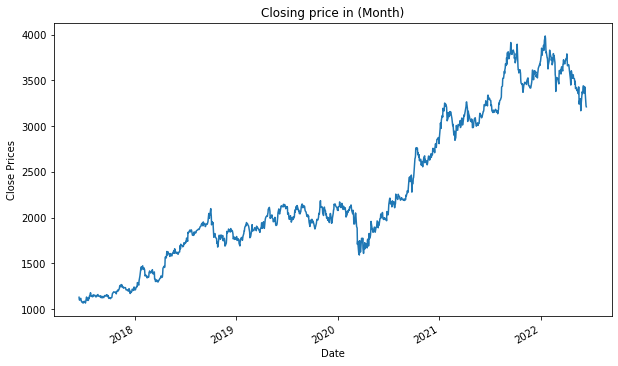

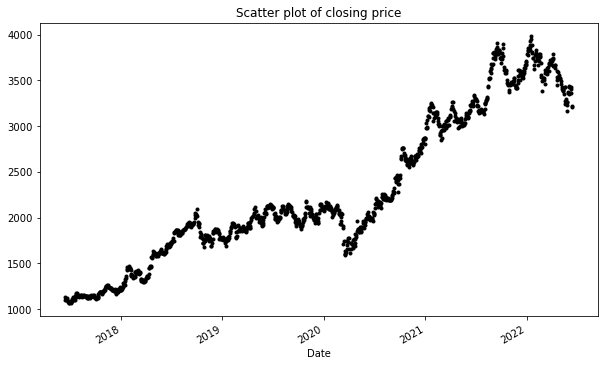

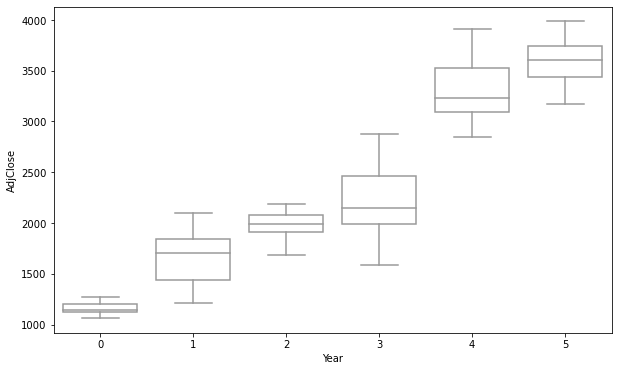

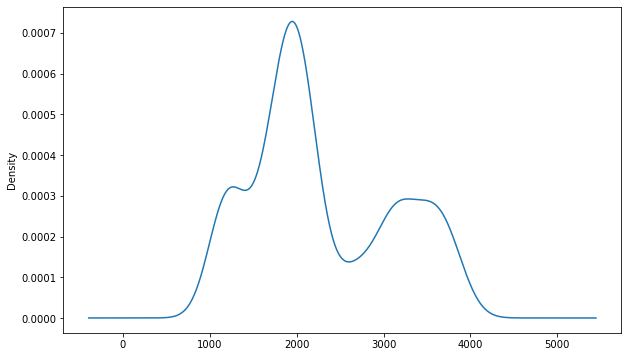

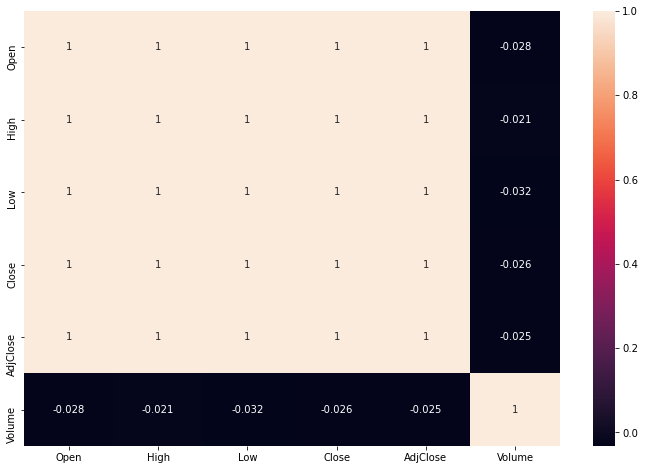

In [10]:
def plot_diagram():
    #plot close price
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.xlabel('Dates')
    plt.ylabel('Close Prices')
    plot1_df = stocks_data.groupby(["Date"])["AdjClose"].mean()
    plot1_df.plot()
    plt.title('Closing price in (Month)')
    plt.show()
    
    #scatter plot of the sales
    plt.figure(figsize=(10,6))
    df_close = stocks_data['AdjClose']
    df_close.plot(style='k.')
    plt.title('Scatter plot of closing price')
    plt.show()

    #Boxplot
    plt.figure(figsize=(10,6))
    data_boxplot = []
    for year in range(2017, 2023):
        data_boxplot.append(stocks_data.loc[(stocks_data.index.year == year)]['AdjClose'])

    import seaborn as sns
    ax = plt.gca()
    sns.boxplot(data=data_boxplot, color='w', whis=1.5)
    ax.set_xlabel('Year')
    ax.set_ylabel('AdjClose')
        
    #Distribution of the dataset
    plt.figure(figsize=(10,6))
    df_close.plot(kind='kde')
    plt.show()
    #We can observe a near-normal distribution(bell-curve) over sales values.
    
    #corelation plot
    corr = stocks_data.corr()
    plt.figure(figsize=(12,8))
    sns.heatmap(corr,annot=True)
plot_diagram()

# Model Building

### 1.ARIMA Model Training

<AxesSubplot:ylabel='Density'>

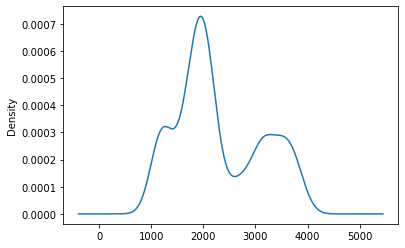

In [11]:
stocks_data['AdjClose'].plot(kind='kde')

#### Stationarity

In [12]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='yellow',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    print(f'Inference: Time Series is {"non" if adft[1]>=0.05 else""} stationary')


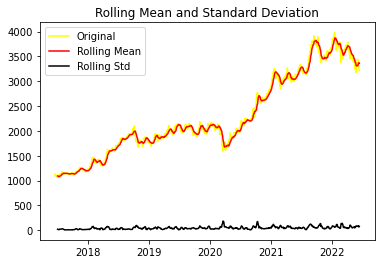

Results of dickey fuller test
Test Statistics                  -1.019519
p-value                           0.746079
No. of lags used                  2.000000
Number of observations used    1233.000000
critical value (1%)              -3.435665
critical value (5%)              -2.863887
critical value (10%)             -2.568020
dtype: float64
Inference: Time Series is non stationary


In [13]:
test_stationarity(stocks_data['AdjClose'])

### Differencing the data

#### Convert our non-stationary data to stationary data using the differencing method.

In [14]:
stock_close_diff = stocks_data['AdjClose'].diff()
stock_close_diff.dropna(inplace=True)
stock_close_diff.head()

Date
2017-06-15   -26.936890
2017-06-16    -5.250610
2017-06-19    14.609985
2017-06-20     6.072266
2017-06-21   -17.668457
Name: AdjClose, dtype: float64

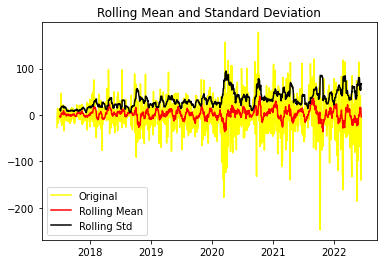

Results of dickey fuller test
Test Statistics                 -26.614134
p-value                           0.000000
No. of lags used                  1.000000
Number of observations used    1233.000000
critical value (1%)              -3.435665
critical value (5%)              -2.863887
critical value (10%)             -2.568020
dtype: float64
Inference: Time Series is  stationary


In [15]:
test_stationarity(stock_close_diff)

### Plotting Seasonal Differnce

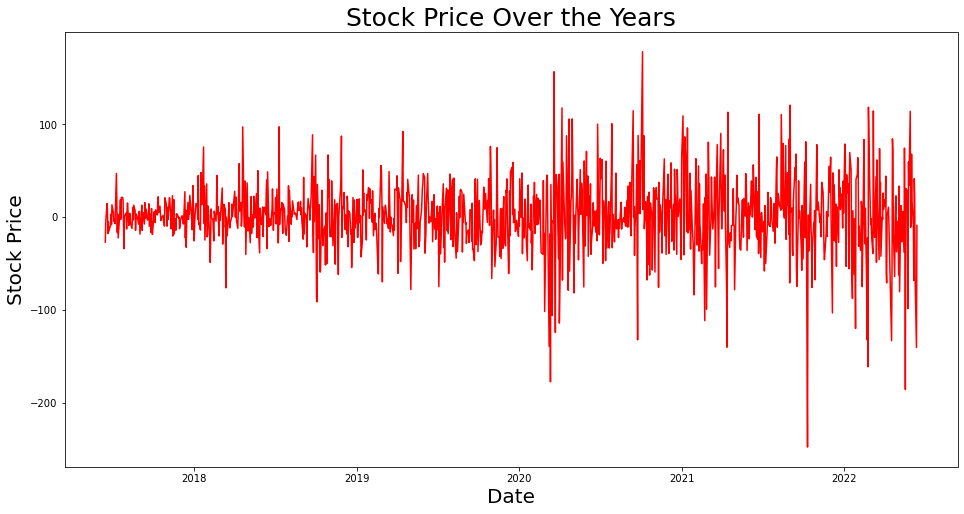

In [16]:
def decompose_data(stock_close):
    plt.figure(figsize=(16,8))
    plt.plot(stock_close, label='Close Seasonal Diff.',color='r')
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Over the Years',size=25);
decompose_data(stock_close_diff)

### Plotting the autocorrelation plot

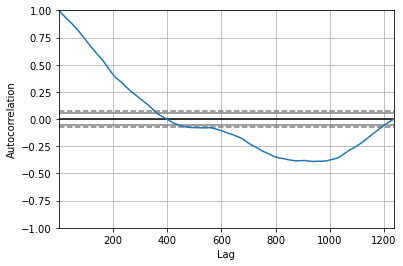

In [17]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(stocks_data['AdjClose'])
plt.show() 

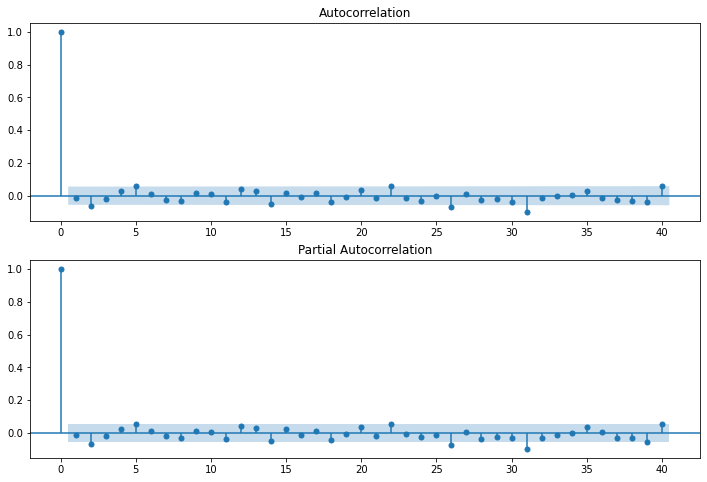

In [18]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(stock_close_diff.dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(stock_close_diff.dropna(),lags=40,ax=ax2)

No handles with labels found to put in legend.


Date
2017-06-14    7.028004
2017-06-15    7.003829
2017-06-16    6.999048
2017-06-19    7.012295
2017-06-20    7.017750
                ...   
2022-06-08    8.132751
2022-06-09    8.139470
2022-06-10    8.119666
2022-06-13    8.077012
2022-06-14    8.074198
Name: AdjClose, Length: 1236, dtype: float64


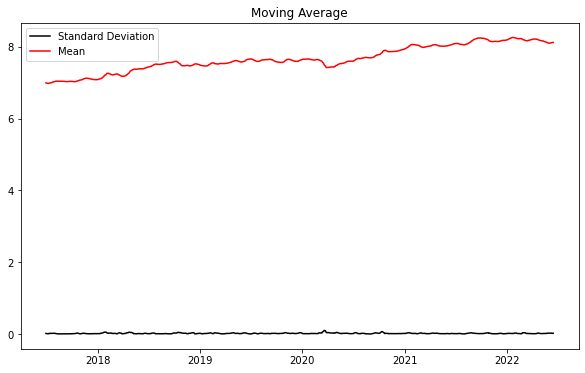

In [19]:
#if not stationary then eliminate trend Eliminate trend
from pylab import rcParams
stock_log = 0
def log_display(stock_close):
    rcParams['figure.figsize'] = 10, 6
    stock_log = np.log(stock_close)
    print(stock_log)
    moving_avg = stock_log.rolling(12).mean()
    std_dev = stock_log.rolling(12).std() 
    plt.legend(loc='best')
    plt.title('Moving Average')
    plt.plot(std_dev, color ="black", label = "Standard Deviation")
    plt.plot(moving_avg, color="red", label = "Mean")
    plt.legend()
    plt.show()
    return stock_log
stock_log = log_display(stocks_data['AdjClose'])

# Split Data into Train and Test

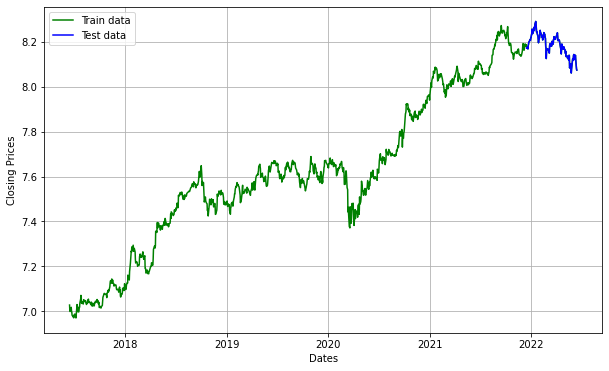

In [20]:
split_data = dict()
def split_data_fn(stk_log):
    stock_train_data, stock_test_data = stk_log[0:int(len(stk_log)*0.9)], stk_log[int(len(stk_log)*0.9):]
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.xlabel('Dates')
    plt.ylabel('Closing Prices')
    plt.plot(stk_log, 'green', label='Train data')
    plt.plot(stock_test_data, 'blue', label='Test data')
    plt.legend()
    split_data["train_data"] = stock_train_data
    split_data["test_data"] = stock_test_data
    return split_data
split_data = split_data_fn(stock_log)

In [21]:
len(split_data["train_data"])

1112

In [22]:
split_data["train_data"]

Date
2017-06-14    7.028004
2017-06-15    7.003829
2017-06-16    6.999048
2017-06-19    7.012295
2017-06-20    7.017750
                ...   
2021-12-08    8.187664
2021-12-09    8.180706
2021-12-10    8.190390
2021-12-13    8.182897
2021-12-14    8.186809
Name: AdjClose, Length: 1112, dtype: float64

In [23]:
lenTestData = len(split_data["test_data"])
lenTestData

124

# Performing Auto Arima

In [24]:
model_autoARIMA = 0
def create_model_autoARIMA(train_data):
    model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
    test='adf',       # use adftest to find optimal 'd'
    max_p=3, max_q=3, # maximum p and q
    m=1,              # frequency of series
    d=None,           # let model determine 'd'
    seasonal=False,   # No Seasonality
    start_P=0, 
    D=0, 
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True)
    print(model_autoARIMA.summary())
    return model_autoARIMA
model_autoARIMA = create_model_autoARIMA(split_data["train_data"])

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5989.188, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5990.338, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5990.571, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5986.652, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5989.015, Time=0.59 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5989.759, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5987.870, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5987.476, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.691 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1112
Model:               SARIMAX(0, 1, 1)   Log Likelihood                2998.286
Date:                Tue, 14 Jun 2022   AIC                          -5990.571
Time:                       

In [25]:
bestOrder = model_autoARIMA.order
bestOrder

(0, 1, 1)

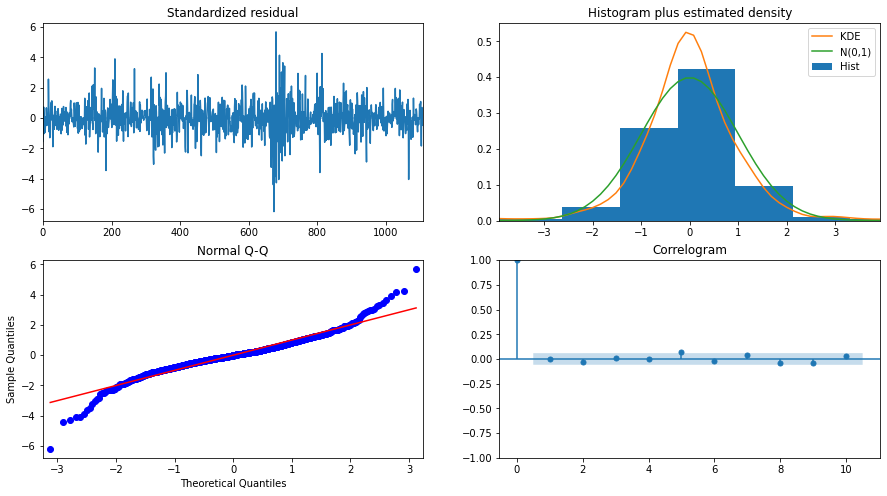

In [26]:
def plot_model_autoARIMA():
    model_autoARIMA.plot_diagnostics(figsize=(15,8))
    plt.show()
plot_model_autoARIMA()

In [27]:
fitted=0
def create_final_model(train_data):
    fitted = model_autoARIMA.fit(train_data)
    print(fitted.summary())
    return fitted
fitted = create_final_model(split_data["train_data"])

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1112
Model:               SARIMAX(0, 1, 1)   Log Likelihood                2998.286
Date:                Tue, 14 Jun 2022   AIC                          -5990.571
Time:                        15:40:32   BIC                          -5975.532
Sample:                             0   HQIC                         -5984.885
                               - 1112                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0010      0.000      2.246      0.025       0.000       0.002
ma.L1         -0.0551      0.022     -2.527      0.012      -0.098      -0.012
sigma2         0.0003   6.29e-06     42.157      0.0

### ARIMA - Prediction

In [28]:
split_data['train_data'].tail()

Date
2021-12-08    8.187664
2021-12-09    8.180706
2021-12-10    8.190390
2021-12-13    8.182897
2021-12-14    8.186809
Name: AdjClose, dtype: float64

In [29]:
predictArima = model_autoARIMA.predict(n_periods=lenTestData)
predictArima = pd.DataFrame(predictArima,index = split_data["test_data"].index,columns=['Prediction'])

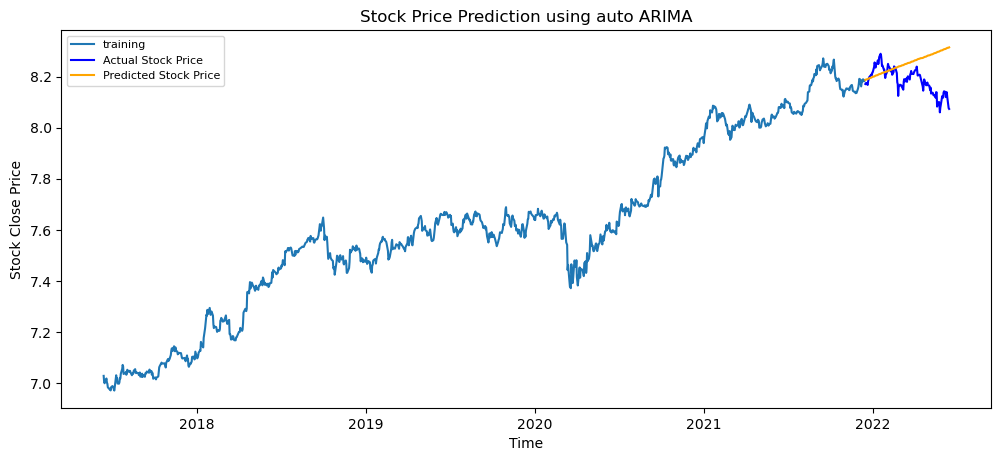

In [30]:
def plot_arima_forecasting(split_data):
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(split_data["train_data"], label='training')
    plt.plot(split_data["test_data"], color = 'blue', label='Actual Stock Price')
    plt.plot(predictArima['Prediction'], color = 'orange',label='Predicted Stock Price')
    plt.title('Stock Price Prediction using auto ARIMA')
    plt.xlabel('Time')
    plt.ylabel('Stock Close Price')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
plot_arima_forecasting(split_data)

In [31]:
predictArima

,Prediction
Date,
2021-12-15,8.187713
2021-12-16,8.188751
2021-12-17,8.189788
2021-12-20,8.190826
2021-12-21,8.191864
...,...
2022-06-08,8.311198
2022-06-09,8.312236
2022-06-10,8.313273


In [32]:
# report performance
tst_data = split_data["test_data"].values.reshape(len(split_data["test_data"]),1)

arima_rmse = math.sqrt(mean_squared_error(tst_data, predictArima))
print('RMSE: '+str(arima_rmse))
arima_mape = np.mean(np.abs(predictArima - tst_data)/np.abs(tst_data))
print('MAPE: '+str(arima_mape.Prediction))

RMSE: 0.10388773242137407
MAPE: 0.009794356016875927


# LSTM Model Training

In [33]:
tmp_data = stocks_data_copy.sort_index(ascending=True, axis=0)
close_stocks_data = np.log(tmp_data["AdjClose"])

In [34]:
len(split_data["test_data"])

124

In [35]:
dataset = close_stocks_data.values
lstm_train = dataset[0:len(split_data["train_data"])]
lstm_test = dataset[len(split_data["train_data"]):]
dataset = dataset.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [36]:
x_train, y_train = [], []
for i in range(60,len(lstm_train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network

In [37]:
LSTM_model = Sequential()
LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
LSTM_model.add(LSTM(units=50))
LSTM_model.add(Dense(1))
LSTM_model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mean_squared_error'])
LSTM_model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

1052/1052 - 15s - loss: 0.0032 - mean_squared_error: 0.0032 - 15s/epoch - 14ms/step


In [38]:
inputs = close_stocks_data[len(close_stocks_data) - len(lstm_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)
print(inputs)
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
print(X_test)

[[0.9616015 ]
 [0.96074003]
 [0.9685168 ]
 [0.96835984]
 [0.96975135]
 [0.97015268]
 [0.9634004 ]
 [0.95190094]
 [0.95445261]
 [0.95117897]
 [0.94202386]
 [0.95072728]
 [0.96267941]
 [0.95823926]
 [0.97436794]
 [0.98264227]
 [0.93291099]
 [0.92614887]
 [0.9266361 ]
 [0.91896566]
 [0.92641804]
 [0.92371273]
 [0.91842008]
 [0.90221996]
 [0.89496854]
 [0.89368992]
 [0.89144172]
 [0.89299557]
 [0.87806523]
 [0.87275488]
 [0.89009177]
 [0.89178974]
 [0.89353808]
 [0.89708756]
 [0.8958125 ]
 [0.89645027]
 [0.89181148]
 [0.89265896]
 [0.9008354 ]
 [0.90666778]
 [0.90732842]
 [0.89994316]
 [0.88993921]
 [0.88615883]
 [0.88743929]
 [0.88284385]
 [0.8834156 ]
 [0.88362447]
 [0.89565033]
 [0.90150115]
 [0.91187356]
 [0.92553465]
 [0.92502499]
 [0.90305594]
 [0.91329099]
 [0.92219986]
 [0.91692813]
 [0.92426503]
 [0.918588  ]
 [0.92155206]
 [0.91029441]
 [0.91267782]
 [0.91325929]
 [0.90743494]
 [0.9183046 ]
 [0.92300366]
 [0.92964127]
 [0.9313355 ]
 [0.93651855]
 [0.93865755]
 [0.93623154]
 [0.94

### LSTM prediction

In [39]:
LSTM_forcast = LSTM_model.predict(X_test)
LSTM_forcast = scaler.inverse_transform(LSTM_forcast)

4/4 [==============================] - 1s 11ms/step


In [40]:
tmp_dataset = LSTM_forcast.flatten()
tmp_test_data = split_data["test_data"].reset_index()
lstm_close_stocks_predictions = pd.DataFrame(index=range(0,len(tmp_dataset)),columns=['Date','Prediction'])
for i in range(0,len(tmp_dataset)):
    lstm_close_stocks_predictions['Date'][i] = tmp_test_data['Date'][i].date()
    lstm_close_stocks_predictions['Prediction'][i] = tmp_dataset[i]
    
lstm_close_stocks_predictions.set_index('Date',inplace=True)    
lstm_close_stocks_predictions


,Prediction
Date,
2021-12-15,8.19473
2021-12-16,8.195394
2021-12-17,8.195552
2021-12-20,8.195424
2021-12-21,8.194578
...,...
2022-06-08,8.137348
2022-06-09,8.140176
2022-06-10,8.143077


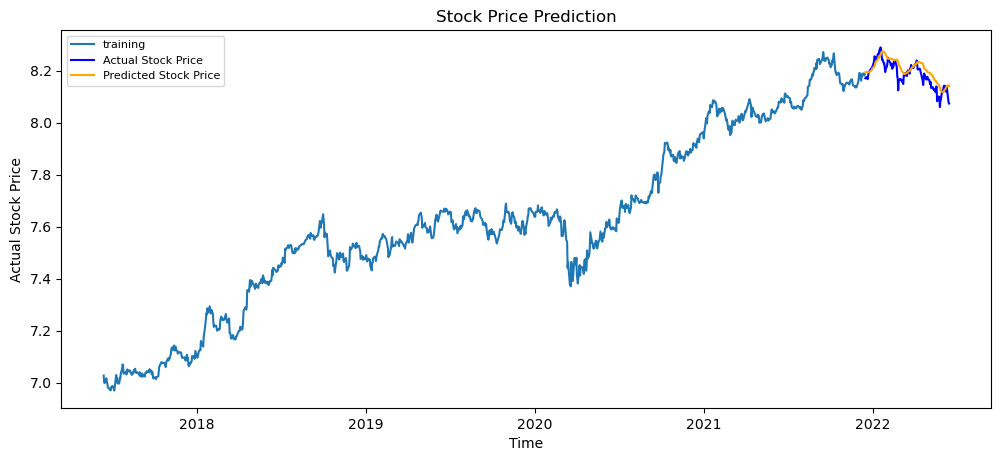

In [41]:
#for plotting
def create_lstm_forecasting(split_data):
    plt.figure(figsize=(12,5), dpi=100)
    #for plotting
    train = close_stocks_data[:len(lstm_train)]
    test = close_stocks_data[len(lstm_train):]
    lstm_Predictions = lstm_close_stocks_predictions
    plt.plot(train,label='training')
    plt.plot(test, color = 'blue', label='Actual Stock Price')
    plt.plot(lstm_Predictions, color = 'orange',label='Predicted Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Actual Stock Price')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
create_lstm_forecasting(split_data)

In [42]:
lstm_rmse = math.sqrt(mean_squared_error(lstm_test, LSTM_forcast))
print('RMSE: '+str(lstm_rmse))
lstm_mape = np.mean(np.abs(LSTM_forcast - lstm_test)/np.abs(lstm_test))
print('MAPE: '+str(lstm_mape))

RMSE: 0.03283307588582537
MAPE: 0.006526751804251247


# Holts winter exponential smoothing with additive seasonality and additive trend

In [43]:
x = 12
alpha = 1/(2*x)

### Single exponential smoothing

<AxesSubplot:title={'center':'Holt Winters Single Exponential Smoothing grpah'}, xlabel='Date'>

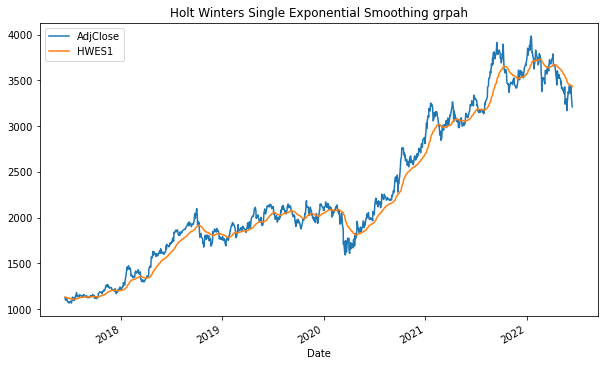

In [44]:
# Single exponential smoothing 
stocks_data['HWES1'] = SimpleExpSmoothing(stocks_data['AdjClose']).fit(smoothing_level=alpha,optimized=False,use_brute=True).fittedvalues      
stocks_data[['AdjClose','HWES1']].plot(title='Holt Winters Single Exponential Smoothing grpah')

In [45]:
stocks_data

,Open,High,Low,Close,AdjClose,Volume,HWES1
Date,,,,,,,
2017-06-14,1227.500000,1238.000000,1227.500000,1235.099976,1127.777100,1489142,1127.777100
2017-06-15,1234.500000,1234.849976,1202.500000,1205.599976,1100.840210,2997198,1127.777100
2017-06-16,1207.474976,1217.500000,1193.250000,1199.849976,1095.589600,2450426,1126.654729
2017-06-19,1208.449951,1223.175049,1202.574951,1215.849976,1110.199585,1644742,1125.360349
2017-06-20,1215.500000,1224.500000,1190.150024,1222.500000,1116.271851,1670958,1124.728650
...,...,...,...,...,...,...,...
2022-06-08,3380.149902,3413.949951,3346.500000,3404.149902,3404.149902,2185707,3447.068085
2022-06-09,3385.000000,3437.000000,3353.100098,3427.100098,3427.100098,1279197,3445.279827
2022-06-10,3382.000000,3393.000000,3352.000000,3359.899902,3359.899902,1527582,3444.522338


### Double exponential smoothing

<AxesSubplot:title={'center':'Holt Winters grapg: Additive Trend and Multiplicative Trend'}, xlabel='Date'>

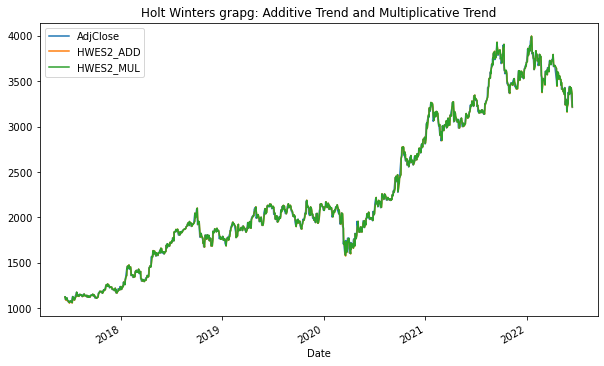

In [46]:
stocks_data['HWES2_ADD'] = ExponentialSmoothing(stocks_data['AdjClose'],trend='add').fit().fittedvalues
stocks_data['HWES2_MUL'] = ExponentialSmoothing(stocks_data['AdjClose'],trend='mul').fit().fittedvalues
stocks_data[['AdjClose','HWES2_ADD','HWES2_MUL']].plot(title='Holt Winters grapg: Additive Trend and Multiplicative Trend')

In [47]:
stocks_data

,Open,High,Low,Close,AdjClose,Volume,HWES1,HWES2_ADD,HWES2_MUL
Date,,,,,,,,,
2017-06-14,1227.500000,1238.000000,1227.500000,1235.099976,1127.777100,1489142,1127.777100,1121.548237,1127.714856
2017-06-15,1234.500000,1234.849976,1202.500000,1205.599976,1100.840210,2997198,1127.777100,1121.160101,1127.714476
2017-06-16,1207.474976,1217.500000,1193.250000,1199.849976,1095.589600,2450426,1126.654729,1094.342155,1100.958800
2017-06-19,1208.449951,1223.175049,1202.574951,1215.849976,1110.199585,1644742,1125.360349,1088.483667,1094.977221
2017-06-20,1215.500000,1224.500000,1190.150024,1222.500000,1116.271851,1670958,1124.728650,1103.204635,1109.335476
...,...,...,...,...,...,...,...,...,...
2022-06-08,3380.149902,3413.949951,3346.500000,3404.149902,3404.149902,2185707,3447.068085,3361.016509,3361.794231
2022-06-09,3385.000000,3437.000000,3353.100098,3427.100098,3427.100098,1279197,3445.279827,3400.593591,3401.047509
2022-06-10,3382.000000,3393.000000,3352.000000,3359.899902,3359.899902,1527582,3444.522338,3424.932691,3425.039875


In [48]:
# Split into train and test set
train_stocks = split_data["train_data"]
test_stocks = split_data["test_data"]

### Fit Model

In [49]:
ExponentialSmoothing_fitted_model = ExponentialSmoothing(train_stocks,trend='mul',seasonal='mul',seasonal_periods=2).fit()
Holt_forecast = ExponentialSmoothing_fitted_model.forecast(lenTestData)  # 95% conf

In [50]:
tmp_holt_dataset = np.array(Holt_forecast.values.tolist())
tmp_test_data = test_stocks.reset_index()
holt_close_stocks_predictions = pd.DataFrame(index=range(0,len(tmp_holt_dataset)),columns=['Date', 'Prediction'])
for i in range(0,len(tmp_holt_dataset)):
    holt_close_stocks_predictions['Date'][i] = tmp_test_data['Date'][i].date()
    holt_close_stocks_predictions['Prediction'][i] = tmp_holt_dataset[i]
      
    
holt_close_stocks_predictions.set_index('Date',inplace=True)    
holt_close_stocks_predictions


,Prediction
Date,
2021-12-15,8.188754
2021-12-16,8.189015
2021-12-17,8.19096
2021-12-20,8.191222
2021-12-21,8.193167
...,...
2022-06-08,8.320222
2022-06-09,8.322198
2022-06-10,8.322464


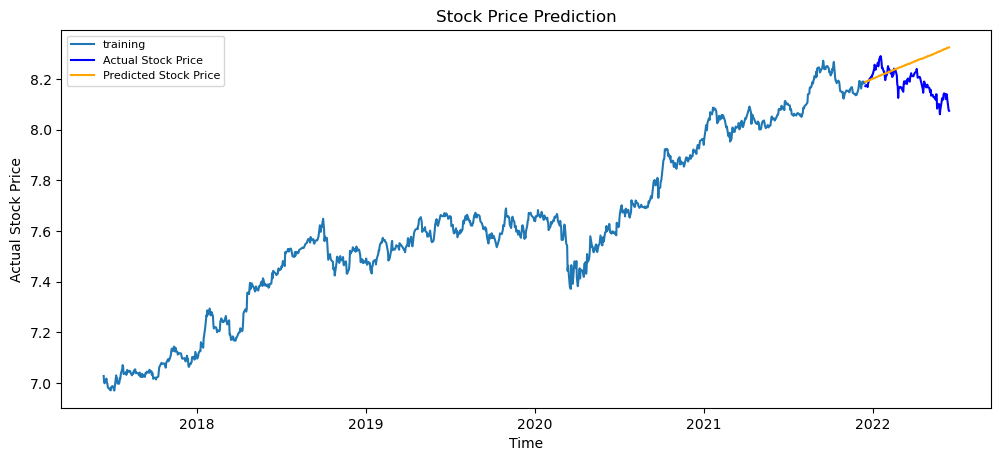

In [51]:

def create_holts_forecasting():
    plt.figure(figsize=(12,5), dpi=100)
    #for plotting
    train = close_stocks_data[:len(train_stocks)]
    test = close_stocks_data[len(train_stocks):]
    plt.plot(train_stocks,label='training')
    plt.plot(test_stocks, color = 'blue', label='Actual Stock Price')
    plt.plot(holt_close_stocks_predictions, color = 'orange',label='Predicted Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Actual Stock Price')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
create_holts_forecasting()

In [52]:
holt_tst_data = np.array(test_stocks.values.tolist()) 
Holt_forecast = np.array(Holt_forecast.values.tolist())

holts_rmse = math.sqrt(mean_squared_error(holt_tst_data, Holt_forecast))
print('RMSE: '+str(holts_rmse))
holts_mape = np.mean(np.abs(Holt_forecast - holt_tst_data)/np.abs(holt_tst_data))
print('MAPE: '+str(holts_mape))

RMSE: 0.108959480499749
MAPE: 0.010281839643584416


In [53]:
data = [[arima_rmse,arima_mape.Prediction], [lstm_rmse,lstm_mape], [holts_rmse,holts_mape]]
df = pd.DataFrame(data, columns=['RMSE','MAPE'],index=['Arima',
                               'LSTM',
                               'HOLTS'])
df

,RMSE,MAPE
Arima,0.103888,0.009794
LSTM,0.032833,0.006527
HOLTS,0.108959,0.010282


# We choose LSTM as best model for forecasting the stock time series data

### Next 30 days Stocks Prediction Using LSTM

In [54]:
past_reference_data = 60 
next_future_days = 30

In [55]:
LSTM_test_data = split_data["test_data"]
len(LSTM_test_data)

124

In [56]:
x_input=LSTM_test_data[len(LSTM_test_data)-past_reference_data:].values.reshape(-1,1)
x_input = scaler.fit_transform(x_input)
x_input = x_input.reshape(1,-1)

In [57]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [58]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=past_reference_data
i=0
while(i<next_future_days):
    
    if(len(temp_input)>past_reference_data):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = LSTM_model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = LSTM_model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.33467638]
61
1 day input [0.71780468 0.83090795 0.84814712 0.90416384 0.84070105 0.84107731
 0.83753904 0.87686136 0.88941004 0.91739367 0.93459043 1.
 0.91234329 0.80551657 0.80778838 0.82404262 0.81603513 0.7717861
 0.56389742 0.47436224 0.60919114 0.72080428 0.69598805 0.59568086
 0.59269175 0.61609081 0.65217457 0.59332103 0.58655073 0.48696651
 0.5406751  0.41083035 0.43111656 0.42082033 0.37723734 0.37175514
 0.38197833 0.31936371 0.44163626 0.43710678 0.12624798 0.17911986
 0.22763258 0.17063963 0.         0.10351012 0.16260273 0.35426788
 0.3362162  0.32101714 0.43266716 0.4605584  0.44561366 0.33347825
 0.4018492  0.43934793 0.32882927 0.09078447 0.0750751  0.33467638]
1 day output [[0.3201536]]
2 day input [0.83090795 0.84814712 0.90416384 0.84070105 0.84107731 0.83753904
 0.87686136 0.88941004 0.91739367 0.93459043 1.         0.91234329
 0.80551657 0.80778838 0.82404262 0.81603513 0.7717861  0.56389742
 0.47436224 0.60919114 0.72080428 0.69598805 0.59568086 0.59269175
 0.

15 day output [[0.3186779]]
16 day input [0.82404262 0.81603513 0.7717861  0.56389742 0.47436224 0.60919114
 0.72080428 0.69598805 0.59568086 0.59269175 0.61609081 0.65217457
 0.59332103 0.58655073 0.48696651 0.5406751  0.41083035 0.43111656
 0.42082033 0.37723734 0.37175514 0.38197833 0.31936371 0.44163626
 0.43710678 0.12624798 0.17911986 0.22763258 0.17063963 0.
 0.10351012 0.16260273 0.35426788 0.3362162  0.32101714 0.43266716
 0.4605584  0.44561366 0.33347825 0.4018492  0.43934793 0.32882927
 0.09078447 0.0750751  0.33467638 0.32015359 0.3116467  0.30699944
 0.30480808 0.30416572 0.30449104 0.3054148  0.30670369 0.30821252
 0.30985117 0.3115648  0.3133201  0.31509757 0.31688559 0.3186779 ]
16 day output [[0.32047105]]
17 day input [0.81603513 0.7717861  0.56389742 0.47436224 0.60919114 0.72080428
 0.69598805 0.59568086 0.59269175 0.61609081 0.65217457 0.59332103
 0.58655073 0.48696651 0.5406751  0.41083035 0.43111656 0.42082033
 0.37723734 0.37175514 0.38197833 0.31936371 0.441636

27 day output [[0.3401292]]
28 day input [0.59332103 0.58655073 0.48696651 0.5406751  0.41083035 0.43111656
 0.42082033 0.37723734 0.37175514 0.38197833 0.31936371 0.44163626
 0.43710678 0.12624798 0.17911986 0.22763258 0.17063963 0.
 0.10351012 0.16260273 0.35426788 0.3362162  0.32101714 0.43266716
 0.4605584  0.44561366 0.33347825 0.4018492  0.43934793 0.32882927
 0.09078447 0.0750751  0.33467638 0.32015359 0.3116467  0.30699944
 0.30480808 0.30416572 0.30449104 0.3054148  0.30670369 0.30821252
 0.30985117 0.3115648  0.3133201  0.31509757 0.31688559 0.3186779
 0.32047105 0.3222633  0.32405412 0.32584316 0.3276307  0.32941711
 0.33120257 0.33298737 0.33477223 0.33655727 0.33834285 0.3401292 ]
28 day output [[0.34191656]]
29 day input [0.58655073 0.48696651 0.5406751  0.41083035 0.43111656 0.42082033
 0.37723734 0.37175514 0.38197833 0.31936371 0.44163626 0.43710678
 0.12624798 0.17911986 0.22763258 0.17063963 0.         0.10351012
 0.16260273 0.35426788 0.3362162  0.32101714 0.4326671

In [59]:
day_new=np.arange(1,past_reference_data+1)
day_pred=np.arange(past_reference_data+1,past_reference_data+1+next_future_days)

In [60]:
lst_output

[[0.3346763849258423],
 [0.3201535940170288],
 [0.3116466999053955],
 [0.30699944496154785],
 [0.3048080801963806],
 [0.30416572093963623],
 [0.3044910430908203],
 [0.3054147958755493],
 [0.30670368671417236],
 [0.3082125186920166],
 [0.30985116958618164],
 [0.3115648031234741],
 [0.3133201003074646],
 [0.3150975704193115],
 [0.3168855905532837],
 [0.3186779022216797],
 [0.32047104835510254],
 [0.32226330041885376],
 [0.32405412197113037],
 [0.3258431553840637],
 [0.3276306986808777],
 [0.3294171094894409],
 [0.33120256662368774],
 [0.33298736810684204],
 [0.3347722291946411],
 [0.3365572690963745],
 [0.3383428454399109],
 [0.34012919664382935],
 [0.341916561126709],
 [0.3437052369117737]]

In [61]:
from datetime import timedelta
from datetime import date
lstm_nxt30_stocks = np.exp(scaler.inverse_transform(lst_output))
future_30days_stock_predictions = pd.DataFrame(index=range(0,next_future_days),columns=['Date', 'Prediction'])
Begindate = date.today()
for i in range(0,next_future_days):
    future_30days_stock_predictions['Date'][i] = Begindate + timedelta(days=i+1)
    future_30days_stock_predictions['Prediction'][i] = lstm_nxt30_stocks[i][0]
      
    
future_30days_stock_predictions.set_index('Date',inplace=True)    
future_30days_stock_predictions

,Prediction
Date,
2022-06-15,3363.42196
2022-06-16,3354.680826
2022-06-17,3349.57116
2022-06-18,3346.783073
2022-06-19,3345.469186
2022-06-20,3345.084141
2022-06-21,3345.279141
2022-06-22,3345.832906
2022-06-23,3346.605714


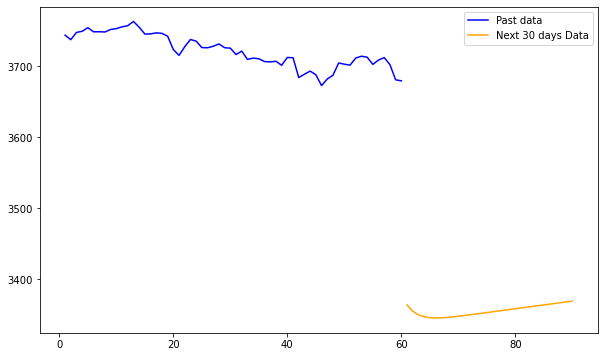

In [62]:
plt.plot(day_new,np.exp(scaler.inverse_transform(scaled_data[len(scaled_data)-past_reference_data:])),color = 'blue',label='Past data')
plt.plot(day_pred,lstm_nxt30_stocks,color = 'orange',label='Next 30 days Data')
plt.legend()
plt.show()

### Create Pickle File

In [63]:
# loading library
# import pickle
# filename = 'finalized_model.h5' 
# LSTM_model.save(filename)